# Predicting Diabetes Using BRFSS Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import make_scorer, recall_score, accuracy_score


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('Diabetes_2022.csv')

In [4]:
y = df.Diabetes_01
X = df.drop(['Diabetes_01'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train:', y_train.shape, 'y_test:', y_test.shape)

X_train: (228311, 24) X_test: (57078, 24)
y_train: (228311,) y_test: (57078,)


### Random Oversampling

In [7]:
ros = RandomOverSampler(random_state=42)
X_over_sampled, y_over_sampled = ros.fit_resample(X_train, y_train)

print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_over_sampled)))

Original dataset shape Counter({0: 192370, 1: 35941})
Resampled dataset shape Counter({0: 192370, 1: 192370})


## Modeling

In [8]:
def optimize_model(model, param_grid, primary_metric="recall", cv=5, X_train = X_train, y_train = y_train):
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'recall': make_scorer(recall_score)
    }
    
    optimizer = GridSearchCV(estimator=model, 
                             param_grid=param_grid, 
                             scoring=scoring, 
                             refit=primary_metric, 
                             cv=cv, 
                             n_jobs=-1, 
                             verbose=True)
    
    optimizer.fit(X_train, y_train)
    print('Best parameters found:')
    print(optimizer.best_params_)
    print(f'\nBest {primary_metric} score: %0.6f' % (optimizer.best_score_))
    if primary_metric == 'recall':
        print(f"Corresponding accuracy: {optimizer.cv_results_['mean_test_accuracy'][optimizer.best_index_]:0.6f}")
    else:
        print(f"Corresponding recall: {optimizer.cv_results_['mean_test_recall'][optimizer.best_index_]:0.6f}")
    
    return optimizer.best_estimator_


In [9]:
def evaluate_model(model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)
    print('\nClassification report: ')
    print(classification_report(y_test, y_pred))

### Logistic Regression

In [10]:
lr_baseline = LogisticRegression(random_state = 0)
lr_baseline.fit(X_over_sampled, y_over_sampled)
print('Best score:', np.round(accuracy_score(y_test, lr_baseline.predict(X_test)), 6))
evaluate_model(lr_baseline)

Best score: 0.718806

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.72      0.81     48132
           1       0.33      0.74      0.45      8946

    accuracy                           0.72     57078
   macro avg       0.63      0.73      0.63     57078
weighted avg       0.84      0.72      0.75     57078



In [12]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10,100],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200]
}
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score)
}
grid_search = GridSearchCV(estimator=lr_baseline, param_grid=param_grid, scoring=scoring, refit='recall', cv=5)
grid_search.fit(X_over_sampled, y_over_sampled)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
best_recall_score = grid_search.best_score_
print("Best Recall Score (used for refit):", best_recall_score)
best_index = grid_search.best_index_  
best_accuracy_score = grid_search.cv_results_['mean_test_accuracy'][best_index]
print("Best Accuracy Score:", best_accuracy_score)

Best Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Best Recall Score (used for refit): 0.7425066278525757
Best Accuracy Score: 0.7259421947289078


In [13]:
lr_model = grid_search.best_estimator_ 

<Figure size 200x100 with 0 Axes>

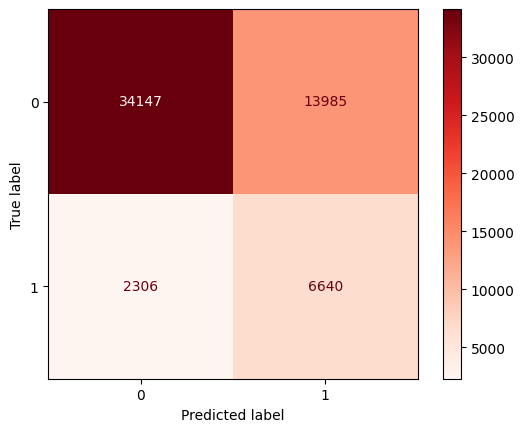

In [14]:
y_pred = lr_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()


### Decision Tree Classifier

In [15]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier())])

tree_param_grid = {'model__criterion': ['gini', 'entropy'],
                   'model__max_depth': [2, 5, 10, 20, 30],
                   'model__min_samples_leaf': [5, 10, 20, 30]}

In [16]:
tree_baseline = DecisionTreeClassifier(random_state = 0)
tree_baseline.fit(X_over_sampled, y_over_sampled)
print('Best score:', np.round(accuracy_score(y_test, tree_baseline.predict(X_test)), 6))
evaluate_model(tree_baseline)

Best score: 0.764305

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     48132
           1       0.28      0.31      0.29      8946

    accuracy                           0.76     57078
   macro avg       0.57      0.58      0.58     57078
weighted avg       0.78      0.76      0.77     57078



In [17]:
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found:
{'model__criterion': 'gini', 'model__max_depth': 30, 'model__min_samples_leaf': 5}

Best recall score: 0.255224
Corresponding accuracy: 0.816995

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     48132
           1       0.38      0.26      0.31      8946

    accuracy                           0.82     57078
   macro avg       0.63      0.59      0.60     57078
weighted avg       0.79      0.82      0.80     57078



In [18]:
tree_model = Pipeline([("scaler", StandardScaler()), ("model", DecisionTreeClassifier(criterion = 'entropy'))])
tree_param_grid = {'model__min_samples_leaf': [3,4,5,6,7,8],
                   'model__max_depth': [30, 35, 40, 45, 50]}
tree_model = optimize_model(tree_model, tree_param_grid)
evaluate_model(tree_model)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:
{'model__max_depth': 35, 'model__min_samples_leaf': 3}

Best recall score: 0.280627
Corresponding accuracy: 0.803833

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     48132
           1       0.35      0.28      0.31      8946

    accuracy                           0.80     57078
   macro avg       0.61      0.59      0.60     57078
weighted avg       0.79      0.80      0.80     57078



<Figure size 200x100 with 0 Axes>

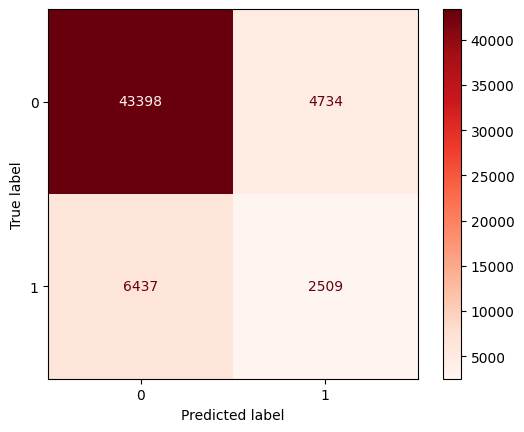

In [19]:
y_pred = tree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

### XGBoost Classifier

In [20]:
xgb_classifier = xgb.XGBClassifier(eval_metric='error', random_state = 0)
xgb_classifier.fit(X_over_sampled, y_over_sampled)
print('Best score:', np.round(accuracy_score(y_test, xgb_classifier.predict(X_test)), 6))
evaluate_model(xgb_classifier)

Best score: 0.715214

Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     48132
           1       0.32      0.75      0.45      8946

    accuracy                           0.72     57078
   macro avg       0.63      0.73      0.63     57078
weighted avg       0.84      0.72      0.75     57078



<Figure size 200x100 with 0 Axes>

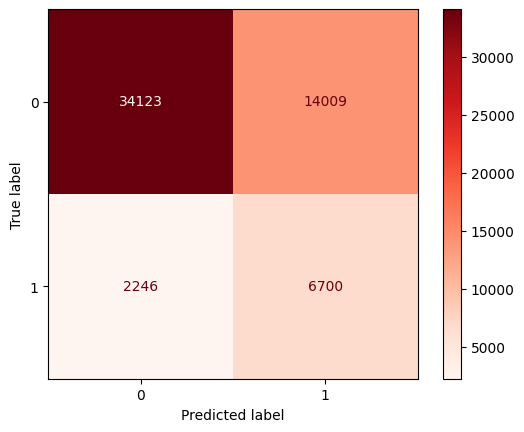

In [21]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(2, 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Reds)
plt.show()

## Metrics

In [22]:
from sklearn import metrics
model_name = []
accuracy_score = []
f1_score = []
roc_auc_score = []
recall_score = []
precision_score = []
    
def metrics_models(name, model, X_test = X_test, y_test = y_test):
    models = list()
    models.append((name, model))
    
    for name, model in models:
        model_name.append(name)
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
        f1_score.append(metrics.f1_score(y_test, model.predict(X_test)))
        roc_auc_score.append(metrics.roc_auc_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))


In [23]:
metrics_models('Base LinearRegression (Random Oversample)', lr_baseline)
metrics_models('LinearRegression (Random Oversample)', lr_model)
metrics_models('Base DecisionTreeClassifier (Random Oversample)', tree_baseline)
metrics_models('DecisionTreeClassifier (Random Oversample)', tree_model)
metrics_models('XGBoostClassifier (Random Oversample)', xgb_classifier)

In [24]:
metric_df_random_oversample = pd.DataFrame({'Model': model_name,
                           'Accuracy': accuracy_score,
                           'F1-score': f1_score,
                           'AUC': roc_auc_score,
                           'Recall': recall_score,
                           'Precision': precision_score})

In [25]:
metric_df_random_oversample

,Model,Accuracy,F1-score,AUC,Recall,Precision
0,Base LinearRegression (Random Oversample),0.718806,0.451470,0.726749,0.738319,0.325145
1,LinearRegression (Random Oversample),0.714584,0.449089,0.725838,0.742231,0.321939
2,Base DecisionTreeClassifier (Random Oversample),0.764305,0.294065,0.580680,0.313213,0.277124
3,DecisionTreeClassifier (Random Oversample),0.804285,0.309964,0.591053,0.280461,0.346403
4,XGBoostClassifier (Random Oversample),0.715214,0.451863,0.728942,0.748938,0.323531


XGBoostClassifier (Random Oversample) stands out as the best-performing model post-oversampling, with the highest recall (0.7489), competitive F1-score (0.4519), and the highest AUC (0.7289). This model balances recall and precision relatively well, making it the most promising candidate for further tuning or deployment.

Linear Regression Models (Base and non-Base) also show strong recall and decent F1-scores, making them solid alternatives if interpretability is a priority or if further tuning can help improve their performance.

DecisionTreeClassifier Models perform the weakest after oversampling. They do not show significant improvements in recall or AUC, so these models may not be ideal for this problem unless further adjustments are made (e.g., hyperparameter tuning, different resampling techniques).